# Data-driven modeling - Tutorial 3 - Physics-informed neural networks

Lecturer: Dominik Klein

## Exercise

Create a Tensorflow model for the uniaxial deformation mode of the BCC cell. Use three layers with 16 nodes in each layer, with softplus activation functions. Use two network architectures:
1. "Simple" neural network without additional physical information. Input: {F11, F22, F33}, output: {P11, P22, P33}
2. Physics-informed neural network: model the hyperelastic potential, use $\boldsymbol{P}=\partial_{\boldsymbol{F}}W$ to calculate the stress

## 1. "Simple" neural network

In [1]:
import numpy  as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Import data

(175, 20)


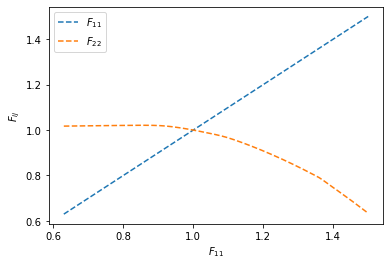

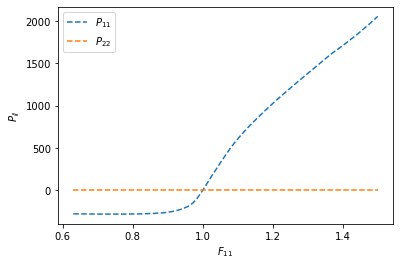

In [2]:
data = np.loadtxt(f'BCC_uniaxial.txt')

print(data.shape)

Fs = np.array((data[:,0], data[:,4], data[:,8])).transpose()
Ps = np.array((data[:,9], data[:,13],data[:,17])).transpose()

Fs = tf.constant(Fs, dtype = tf.float32)
Ps = tf.constant(Ps, dtype = tf.float32)

plt.plot(Fs[:,0], Fs[:,0], linestyle='--', label='$F_{11}$')
plt.plot(Fs[:,0], Fs[:,1], linestyle='--', label='$F_{22}$')
plt.xlabel('$F_{11}$')
plt.ylabel('$F_{ij}$')
plt.legend()
plt.show()

plt.plot(Fs[:,0], Ps[:,0], linestyle='--', label='$P_{11}$')
plt.plot(Fs[:,0], Ps[:,1], linestyle='--', label='$P_{22}$')
plt.xlabel('$F_{11}$')
plt.ylabel('$P_{ij}$')
plt.legend()
plt.show()

### Define model

In [3]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(8, 'softplus', input_shape=[3]),
    tf.keras.layers.Dense(8, 'softplus'),
    tf.keras.layers.Dense(8, 'softplus'),
    tf.keras.layers.Dense(3)
    ])

         
model1.summary()

model1.compile('adam', 'mse')

model1.evaluate(Fs, Ps)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 27        
Total params: 203
Trainable params: 203
Non-trainable params: 0
_________________________________________________________________
6/6 [==============================] - 0s 3ms/step - loss: 328096.3750


328096.375

### Calibrate and evaluate model

Epoch 1/100
6/6 - 0s - loss: 328064.3750
Epoch 2/100
6/6 - 0s - loss: 327966.0938
Epoch 3/100
6/6 - 0s - loss: 327876.5000
Epoch 4/100
6/6 - 0s - loss: 327789.0625
Epoch 5/100
6/6 - 0s - loss: 327701.8438
Epoch 6/100
6/6 - 0s - loss: 327614.0000
Epoch 7/100
6/6 - 0s - loss: 327533.9062
Epoch 8/100
6/6 - 0s - loss: 327449.0625
Epoch 9/100
6/6 - 0s - loss: 327368.7812
Epoch 10/100
6/6 - 0s - loss: 327286.9375
Epoch 11/100
6/6 - 0s - loss: 327202.9688
Epoch 12/100
6/6 - 0s - loss: 327116.3750
Epoch 13/100
6/6 - 0s - loss: 327036.5312
Epoch 14/100
6/6 - 0s - loss: 326943.0938
Epoch 15/100
6/6 - 0s - loss: 326853.7188
Epoch 16/100
6/6 - 0s - loss: 326756.9062
Epoch 17/100
6/6 - 0s - loss: 326651.2500
Epoch 18/100
6/6 - 0s - loss: 326542.0938
Epoch 19/100
6/6 - 0s - loss: 326423.1875
Epoch 20/100
6/6 - 0s - loss: 326294.2812
Epoch 21/100
6/6 - 0s - loss: 326159.2812
Epoch 22/100
6/6 - 0s - loss: 326013.9375
Epoch 23/100
6/6 - 0s - loss: 325849.0938
Epoch 24/100
6/6 - 0s - loss: 325685.0625
E

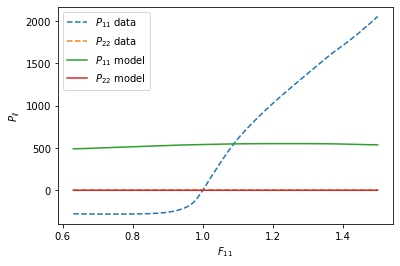

In [4]:
h= model1.fit(Fs, Ps, epochs=100, verbose=2)

Ps_model = model1.predict(Fs)

plt.plot(Fs[:,0], Ps[:,0], linestyle='--', label='$P_{11}$ data')
plt.plot(Fs[:,0], Ps[:,1], linestyle='--', label='$P_{22}$ data')
plt.plot(Fs[:,0], Ps_model[:,0], label='$P_{11}$ model')
plt.plot(Fs[:,0], Ps_model[:,1], label='$P_{22}$ model')
plt.xlabel('$F_{11}$')
plt.ylabel('$P_{ij}$')
plt.legend()
plt.show()

## 2. Physics-informed neural network

### Define model

In [5]:
def WP(**kwargs):
    Fs = tf.keras.Input(shape=[3])
    Ps = _F_to_P(**kwargs)(Fs)
    model = tf.keras.Model(Fs, Ps)
    model.compile('adam', 'mse')
    return model


class _F_to_P(tf.keras.layers.Layer):
    """
    Internal
    """
    
    def __init__(self, **kwargs):
        super(_F_to_P, self).__init__()
        self.W = _F_to_W(**kwargs)
        
    def call(self, Fs):
        with tf.GradientTape() as tape:
            tape.watch(Fs)
            Ws = self.W(Fs)
        Ps = tape.gradient(Ws, Fs)
        return Ps
    
    
class _F_to_W(tf.keras.layers.Layer):
    """
    Trainable
    """
    
    def __init__(self, ns = [16, 16, 16]):
        super(_F_to_W, self).__init__()
        self.l0 = tf.keras.layers.Dense(ns[0], 'softplus', use_bias=True)
        self.ls = [tf.keras.layers.Dense(n, 'softplus', \
                        use_bias=True, \
                        kernel_constraint=tf.keras.constraints.non_neg()) \
                   for n in ns[1:]]
        self.ls.append(tf.keras.layers.Dense(1, \
                        use_bias=True, \
                        kernel_constraint=tf.keras.constraints.non_neg()))

        
    def W_core(self, Fs):
        
        x = self.l0(Fs)
            
        for l in self.ls:
            x = l(x)
                
        return x
        
    def call(self, Fs):
        return self.W_core(Fs)
    
    
model2=WP()

model2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
private_f_to_p (_F_to_P)     (None, 3)                 625       
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________


### Calibrate and evaluate model

Epoch 1/100
6/6 - 0s - loss: 327095.6875
Epoch 2/100
6/6 - 0s - loss: 327029.6250
Epoch 3/100
6/6 - 0s - loss: 326973.4062
Epoch 4/100
6/6 - 0s - loss: 326907.0625
Epoch 5/100
6/6 - 0s - loss: 326822.7812
Epoch 6/100
6/6 - 0s - loss: 326723.2188
Epoch 7/100
6/6 - 0s - loss: 326612.3125
Epoch 8/100
6/6 - 0s - loss: 326461.8438
Epoch 9/100
6/6 - 0s - loss: 326288.3438
Epoch 10/100
6/6 - 0s - loss: 326069.0625
Epoch 11/100
6/6 - 0s - loss: 325847.2188
Epoch 12/100
6/6 - 0s - loss: 325527.8750
Epoch 13/100
6/6 - 0s - loss: 325187.8438
Epoch 14/100
6/6 - 0s - loss: 324781.0312
Epoch 15/100
6/6 - 0s - loss: 324292.4375
Epoch 16/100
6/6 - 0s - loss: 323721.2188
Epoch 17/100
6/6 - 0s - loss: 323061.7500
Epoch 18/100
6/6 - 0s - loss: 322282.5000
Epoch 19/100
6/6 - 0s - loss: 321392.8438
Epoch 20/100
6/6 - 0s - loss: 320426.0000
Epoch 21/100
6/6 - 0s - loss: 319351.5000
Epoch 22/100
6/6 - 0s - loss: 317989.0000
Epoch 23/100
6/6 - 0s - loss: 316709.8750
Epoch 24/100
6/6 - 0s - loss: 315166.8438
E

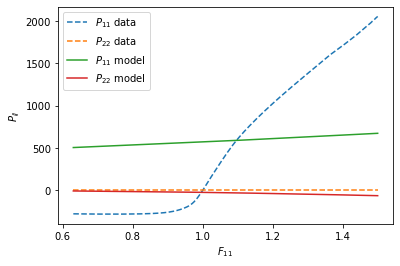

In [6]:
h= model2.fit(Fs, Ps, epochs=100, verbose=2)

Ps_model_2 = model2.predict(Fs)

plt.plot(Fs[:,0], Ps[:,0], linestyle='--', label='$P_{11}$ data')
plt.plot(Fs[:,0], Ps[:,1], linestyle='--', label='$P_{22}$ data')
plt.plot(Fs[:,0], Ps_model_2[:,0], label='$P_{11}$ model')
plt.plot(Fs[:,0], Ps_model_2[:,1], label='$P_{22}$ model')
plt.xlabel('$F_{11}$')
plt.ylabel('$P_{ij}$')
plt.legend()
plt.show()